In [2]:
# plotting inline
%matplotlib inline

# working directory
from pathlib import Path

dir_path = Path('./')

# importing necessary modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
import matplotlib.font_manager as fm
from IPython.display import HTML
from tqdm import tqdm

# turning off automatic plot showing, and setting style
plt.style.use('fivethirtyeight')

In [3]:

# class for our row of bandits
class MAB:
    
    # initialization
    def __init__(self, bandit_probs):
        
        # storing bandit probs
        self.bandit_probs = bandit_probs
        
    # function that helps us draw from the bandits
    def draw(self, k):

        # we return the reward and the regret of the action
        # 총 N개 중 n개의 무작위 난수 생성 self.bandit_probs[k] 확률에 대한 난수 산출
        return np.random.binomial(1, self.bandit_probs[k]), np.max(self.bandit_probs) - self.bandit_probs[k]

In [4]:
# defining a set of bandits with known probabilites
# 의도하고자 하는 확률 정의(시뮬레이션 환경 고려)
bandit_probs = [0.01, 0.03, 0.05, 0.08]

In [5]:
# instance of our MAB class
mab = MAB(bandit_probs)

# number of draws
N_DRAWS = 500

# number of bandits
N_BANDITS = len(mab.bandit_probs)

In [7]:
# numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# lists for ease of use, visualization
k_list = []
reward_list = []

In [8]:
reward_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# Visualization Part
# opening figure and seeting style
# fig, ax = plt.subplots(figsize=(9, 3), dpi=150)
# ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))

# colors for bandit
bandit_color = ['red', 'green', 'blue', 'purple']

#loop generating draws
for draw_number in range(N_DRAWS):

    # choosing arm and drawing
    # K번째 밴딧에 확률 구할 수 있음
    k = np.random.choice(range(N_BANDITS),2)[0]
    reward, regret = mab.draw(k)

    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward

    #getting list of colors that tells us the bandit
    color_list = [bandit_color[k] for k in k_list]

    #getting list of facecolor that tells up the reward
    facecolor_list = [['none', bandit_color[k_list[i]]][r]
                        for i, r
                        in enumerate(reward_list)]


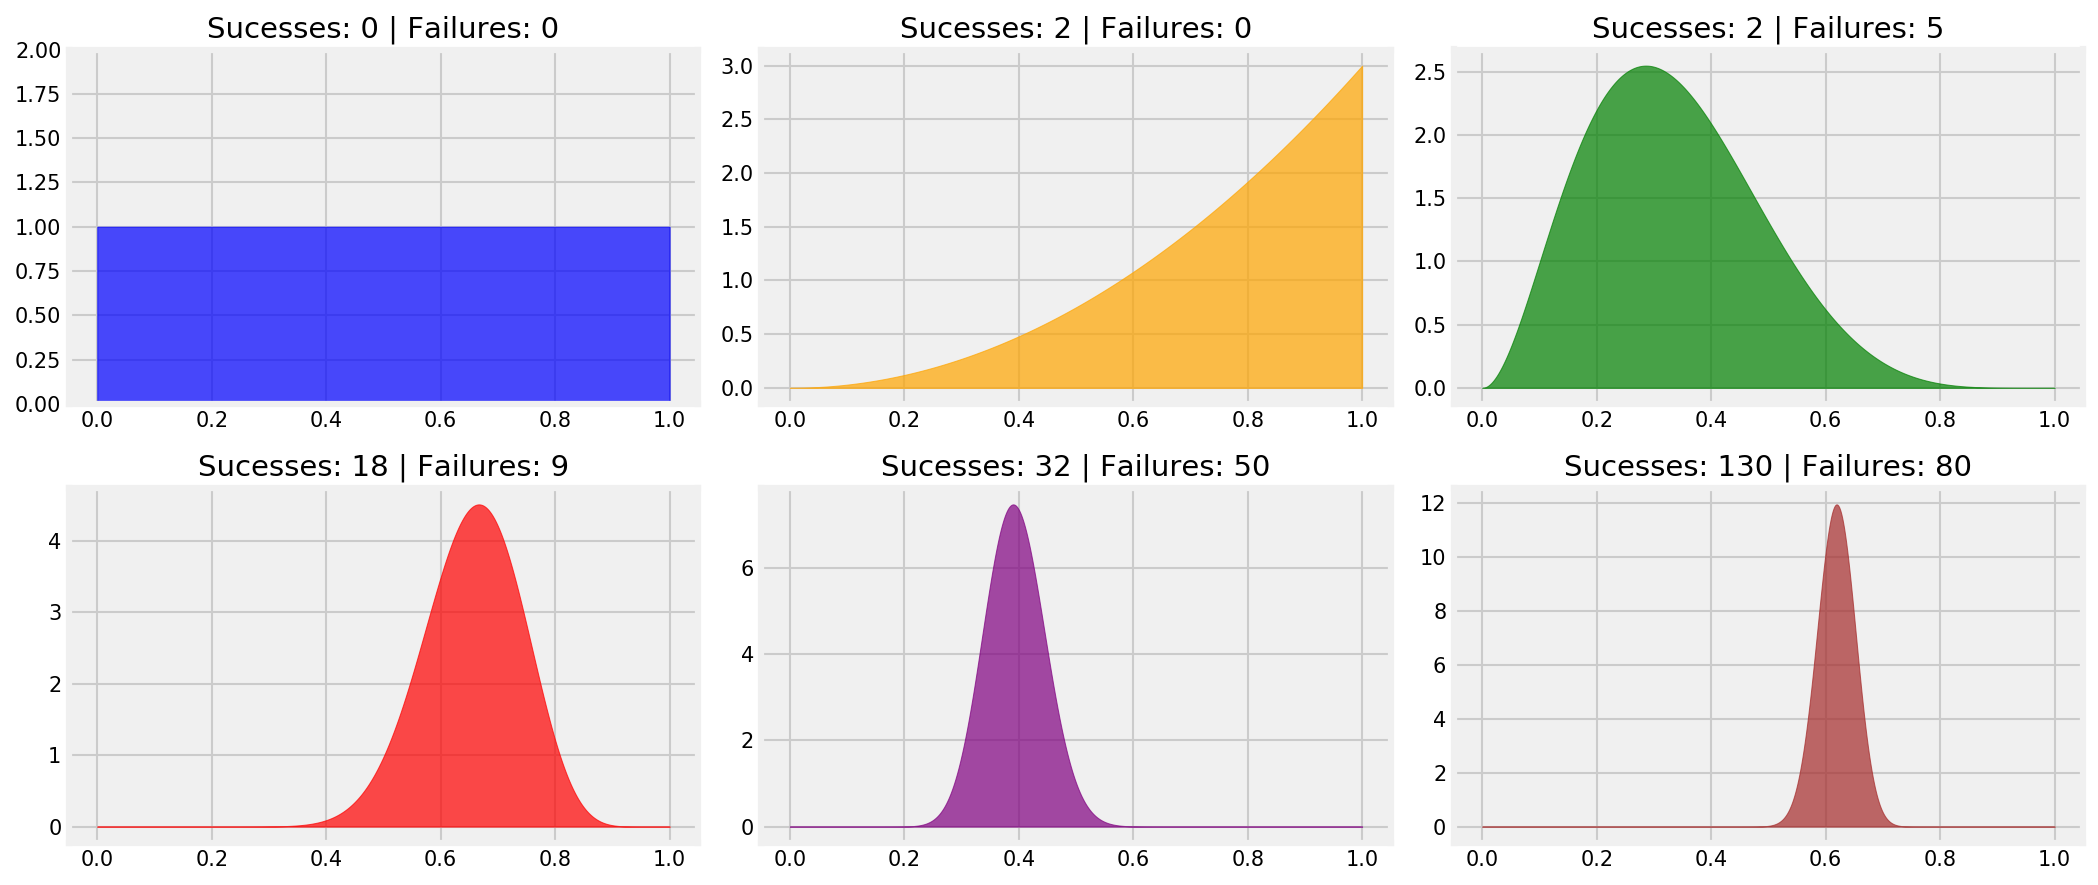

In [11]:
# examples 
beta_examples = [(0,0),(2,0),(2,5),(18,9),(32,50),(130,80)]

# colors for the plots
beta_colors = ['blue','orange','green','red','purple','brown']

# opening figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=150, nrows=2, ncols=3)

# loop for each 
for i, example in enumerate(beta_examples):
    
    # points to sample for drawing the curve
    X = np.linspace(0,1,1000)
    
    # generating the curve
    dist = beta_dist(1 + example[0],1 + example[1])
    curve = dist.pdf(X)
    
    # plotly data
    ax[int(i/3)][(i % 3)].fill_between(X, 0, curve, color=beta_colors[i], alpha=0.7)
    ax[int(i/3)][(i % 3)].set_title('Sucesses: {} | Failures: {}'.format(example[0],example[1]), fontsize=14)

# some adjustments
ax[0][0].set(ylim=[0,2])
plt.tight_layout()
#plt.

# showing the figure
# plt.show()

In [13]:
# let us create a function that returns the pdf for our beta posteriors
# get pdf given alpha, beta
def get_beta_pdf(alpha, beta):
    X = np.linspace(0,1,1000)
    return X, beta_dist(1 + alpha,1 + beta).pdf(X)

In [14]:
# for now, let us perform random draws
def random_policy(k_array, reward_array, n_bandits):
    return np.random.choice(range(n_bandits),1)[0]

In [15]:
# let us wrap a function that draws the draws and distributions of the bandit experiment
def plot_MAB_experiment(decision_policy, N_DRAWS, bandit_probs, plot_title):

    # clearing past figures
    plt.close('all')

    # number of bandits
    N_BANDITS = len(bandit_probs)
    
    # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
    k_array = np.zeros((N_BANDITS,N_DRAWS))
    reward_array = np.zeros((N_BANDITS,N_DRAWS))
    
    # lists for accumulating draws, bandit choices and rewards
    k_list = []
    reward_list = []

    # animation dict for the posteriors
    posterior_anim_dict = {i:[] for i in range(N_BANDITS)}

    # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=4, rowspan=3)
    ax2 = plt.subplot2grid((5, 4), (3, 0), rowspan=2)
    ax3 = plt.subplot2grid((5, 4), (3, 1), rowspan=2)
    ax4 = plt.subplot2grid((5, 4), (3, 2), rowspan=2)
    ax5 = plt.subplot2grid((5, 4), (3, 3), rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        k = decision_policy(k_array, reward_array, N_BANDITS)
        reward, regret = mab.draw(k)

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)
        k_array[k, draw_number] = 1
        reward_array[k, draw_number] = reward
        
        # sucesses and failures for our beta distribution
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
        
        # calculating pdfs for each bandit
        for bandit_id in range(N_BANDITS):

            # pdf
            X, curve = get_beta_pdf(success_count[bandit_id], failure_count[bandit_id])

            # appending to posterior animation dict
            posterior_anim_dict[bandit_id].append({'X': X, 'curve': curve})

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]
    return X, curve

In [16]:
# 트레이드 오프가 발생하기 때문에 다양한 정책을 두고 실험을 해보자
## 1. E-Greedy (입실론-그리디) policy
### -> 가장 확률이 높은 정책을 선택하며, 입실론(e)만큼의 확률로 랜덤 샘플링 한다.
### -> 단, 이때 최대 확률인 값은 제외한다
class Greedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        
    def choose_bandit(self, k_array, reward_array, bandit_num):
        success_count = reward_array.sum(axis = 1)
        total_count = k_array.sum(axis = 1)
        success_ratio = success_count/total_count

        if np.random.random() < self.epsilon:
            return np.random.choice(np.delete(list(range(bandit_num)), np.argmax(success_ratio)))
        else:
            return np.argmax(success_ratio)

In [17]:
# 트레이드 오프가 발생하기 때문에 다양한 정책을 두고 실험을 해보자
## 2. UCB policy
### -> 확률 + UCB_term의 합이 가장 큰 값을 고른다
class UCB:
    def __init__(self):
        pass
    
    def choose_bandit(self, k_array, reward_array, bandit_num):
        success_count = reward_array.sum(axis = 1)
        total_count = k_array.sum(axis = 1)
        success_ratio = success_count/total_count

        #UCB term
        #sqrt(2log(sum of total count)) / total count
        ucb_value = np.sqrt(2*np.log(np.sum(total_count))/total_count)

        return np.argmax(success_ratio + ucb_value)

In [18]:
# 트레이드 오프가 발생하기 때문에 다양한 정책을 두고 실험을 해보자
## 3. thompson sampling
### -> 각 밴딧의 결과로 Beta_dist-> 랜덤sampling -> prob 도출 -> 가장 큰 밴딧 고른다
class Thompson:
    def __init__(self):
        pass

    def choose_bandit(self, k_array, reward_array, bandit_num):
        success_count = reward_array.sum(axis = 1)
        total_count = k_array.sum(axis = 1)

        #UCB term
        prob_list = [
            np.random.beta(i+1, k+1)
            for i, k
            in zip(success_count, total_count-success_count)
        ]

        return np.argmax(prob_list)

In [19]:
# simulation
# number of rounds
N_ROUNDS = 1000

# number of simulations
N_SIMULATIONS = 1000

In [20]:
# define policy
e_greedy_policy = Greedy(0.10)
ucb_policy = UCB()
ts_policy = Thompson()

In [11]:
# dict storing each decision policy
dp_dict = {'e_greedy': e_greedy_policy.choose_bandit, 
           'ucb': ucb_policy.choose_bandit, 
           'ts': ts_policy.choose_bandit}

# dict storing results for each algorithm and simulation
results_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ucb':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ts':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'regret_array': np.zeros((1,N_ROUNDS))[0]}}

# loop for each algorithm
for key, decision_policy in dp_dict.items():
    
    # printing progress
    print(key, decision_policy)
    
    # loop for each simulation
    for simulation in tqdm(range(N_SIMULATIONS)):
        
        # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
        k_array = np.zeros((N_BANDITS,N_ROUNDS))
        reward_array = np.zeros((N_BANDITS,N_ROUNDS))
        regret_array = np.zeros((1,N_ROUNDS))[0]
       
        # loop for each round
        for round_id in range(N_ROUNDS):

            # choosing arm nad pulling it
            k = decision_policy(k_array, reward_array, N_BANDITS)
            reward, regret = mab.draw(k)
            
            # record information about this draw
            k_array[k, round_id] = 1
            reward_array[k, round_id] = reward
            regret_array[round_id] = regret
            
        # results for the simulation
        results_dict[key]['k_array'] += k_array
        results_dict[key]['reward_array'] += reward_array
        results_dict[key]['regret_array'] += regret_array

NameError: name 'e_greedy_policy' is not defined

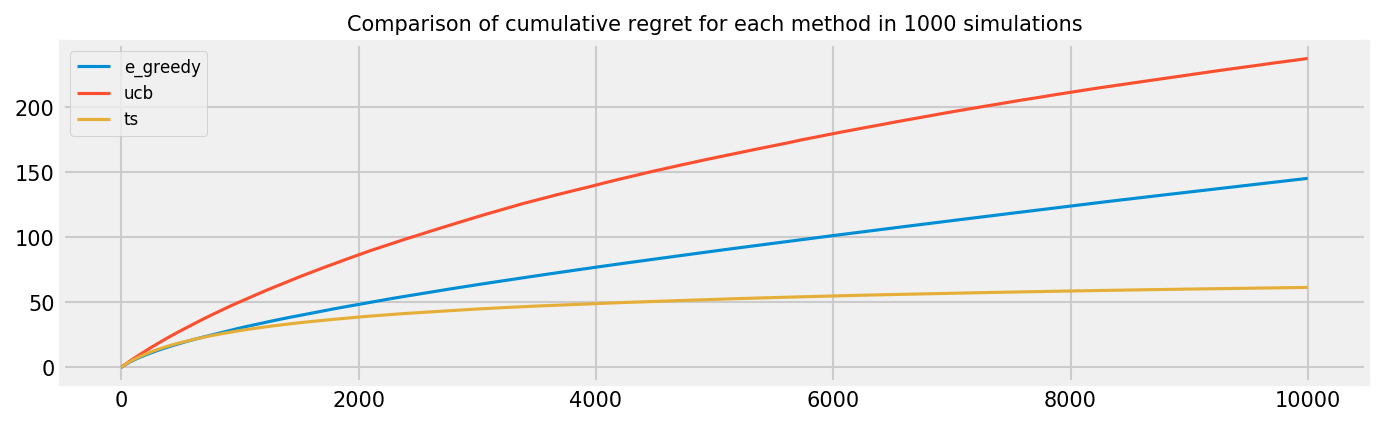

In [18]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# loop for each decision policy
for policy in ['e_greedy','ucb','ts']:
    
    # plotting data
    plt.plot(np.cumsum(results_dict[policy]['regret_array']/N_SIMULATIONS), label=policy, linewidth=1.5);
    
# adding title
plt.title('Comparison of cumulative regret for each method in {} simulations'.format(N_SIMULATIONS), fontsize=10)

# adding legend
plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

# showing plot
plt.show()

In [19]:
def str_format(x):
    return str(round(x*100,1)) + "%"

In [20]:
def result_summary(r_dict, policy):
    temp_dict = r_dict[policy]
    for j in range(0, 10000, 1000):
        count_list = []
        for i in range(4):
            count_list.append(temp_dict['k_array'][i][:j].sum())
        sum_list = sum(count_list)
        if sum_list != 0:
            count_list = count_list/sum_list
    print("bandit0:{t1}, bandit1:{t2}, bandit2:{t3}, bandit3:{t4}".format(t1=str_format(count_list[0]),
                                                                          t2=str_format(count_list[1]), 
                                                                          t3=str_format(count_list[2]), 
                                                                          t4=str_format(count_list[3])))

In [21]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# colors for each bandit
bandit_colors = ['red', 'green', 'blue', 'purple']

# loop for each decision policy
for i, policy in enumerate(['e_greedy','ucb','ts']):
    
    # subplots
    plt.subplot(1,3,i+1)
    
    # loop for each arm
    for arm in range(N_BANDITS):
    
        # plotting data
        plt.plot(results_dict[policy]['k_array'][arm]/N_SIMULATIONS, label='Bandit {}'.format(arm), linewidth=1.5, color=bandit_colors[arm]);
    
        # adding title
        plt.title('Algorithm {} proportion of arm selection'.format(policy), fontsize=8)

        # adding legend
        plt.legend(fontsize=8); plt.xticks(fontsize=8); plt.yticks(fontsize=8); plt.ylim([-0.1,1.1])

# showing plot
for policy in ['e_greedy','ucb','ts']:
    result_summary(results_dict, policy)

plt.show()

bandit0:11.1%, bandit1:81.3%, bandit2:4.1%, bandit3:3.5%
bandit0:18.6%, bandit1:68.1%, bandit2:8.5%, bandit3:4.8%
bandit0:6.4%, bandit1:90.6%, bandit2:2.0%, bandit3:1.0%


In [21]:
# dict storing each decision policy
dp_dict = {'e_greedy': e_greedy_policy.choose_bandit, 
           'ucb': ucb_policy.choose_bandit, 
           'ts': ts_policy.choose_bandit}

# dict storing results for each algorithm and simulation
results_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ucb':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ts':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'regret_array': np.zeros((1,N_ROUNDS))[0]}}

# loop for each algorithm
for key, decision_policy in dp_dict.items():
    
    # printing progress
    print(key, decision_policy)
        
    # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
    k_array = np.zeros((N_BANDITS,N_ROUNDS))
    reward_array = np.zeros((N_BANDITS,N_ROUNDS))
    regret_array = np.zeros((1,N_ROUNDS))[0]
    
    # loop for each round
    for round_id in range(N_ROUNDS):

        # choosing arm nad pulling it
        k = decision_policy(k_array, reward_array, N_BANDITS)
        reward, regret = mab.draw(k)
        
        # record information about this draw
        k_array[k, round_id] = 1
        reward_array[k, round_id] = reward
        regret_array[round_id] = regret

    # draw_sample = [1, 1, 3, 10, 10, 50, 100, 600, 800, 1000]

    # for j, i in enumerate(draw_sample):
    #     plt.subplot(5, 2, j + 1)
    #     plot_priors(i, k_array, reward_array)
    #     plt.autoscale(tight=True)
    # plt.xlabel('value')
    # plt.ylabel('dense')
    # plt.title('n차례 시도후 각 캠페인에 대한 사후확률분포')
    # plt.tight_layout()


ucb <bound method UCB.choose_bandit of <__main__.UCB object at 0x7f38058bce48>>
ts <bound method Thompson.choose_bandit of <__main__.Thompson object at 0x7f38058bca58>>
e_greedy <bound method Greedy.choose_bandit of <__main__.Greedy object at 0x7f38058bcc50>>
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divi

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


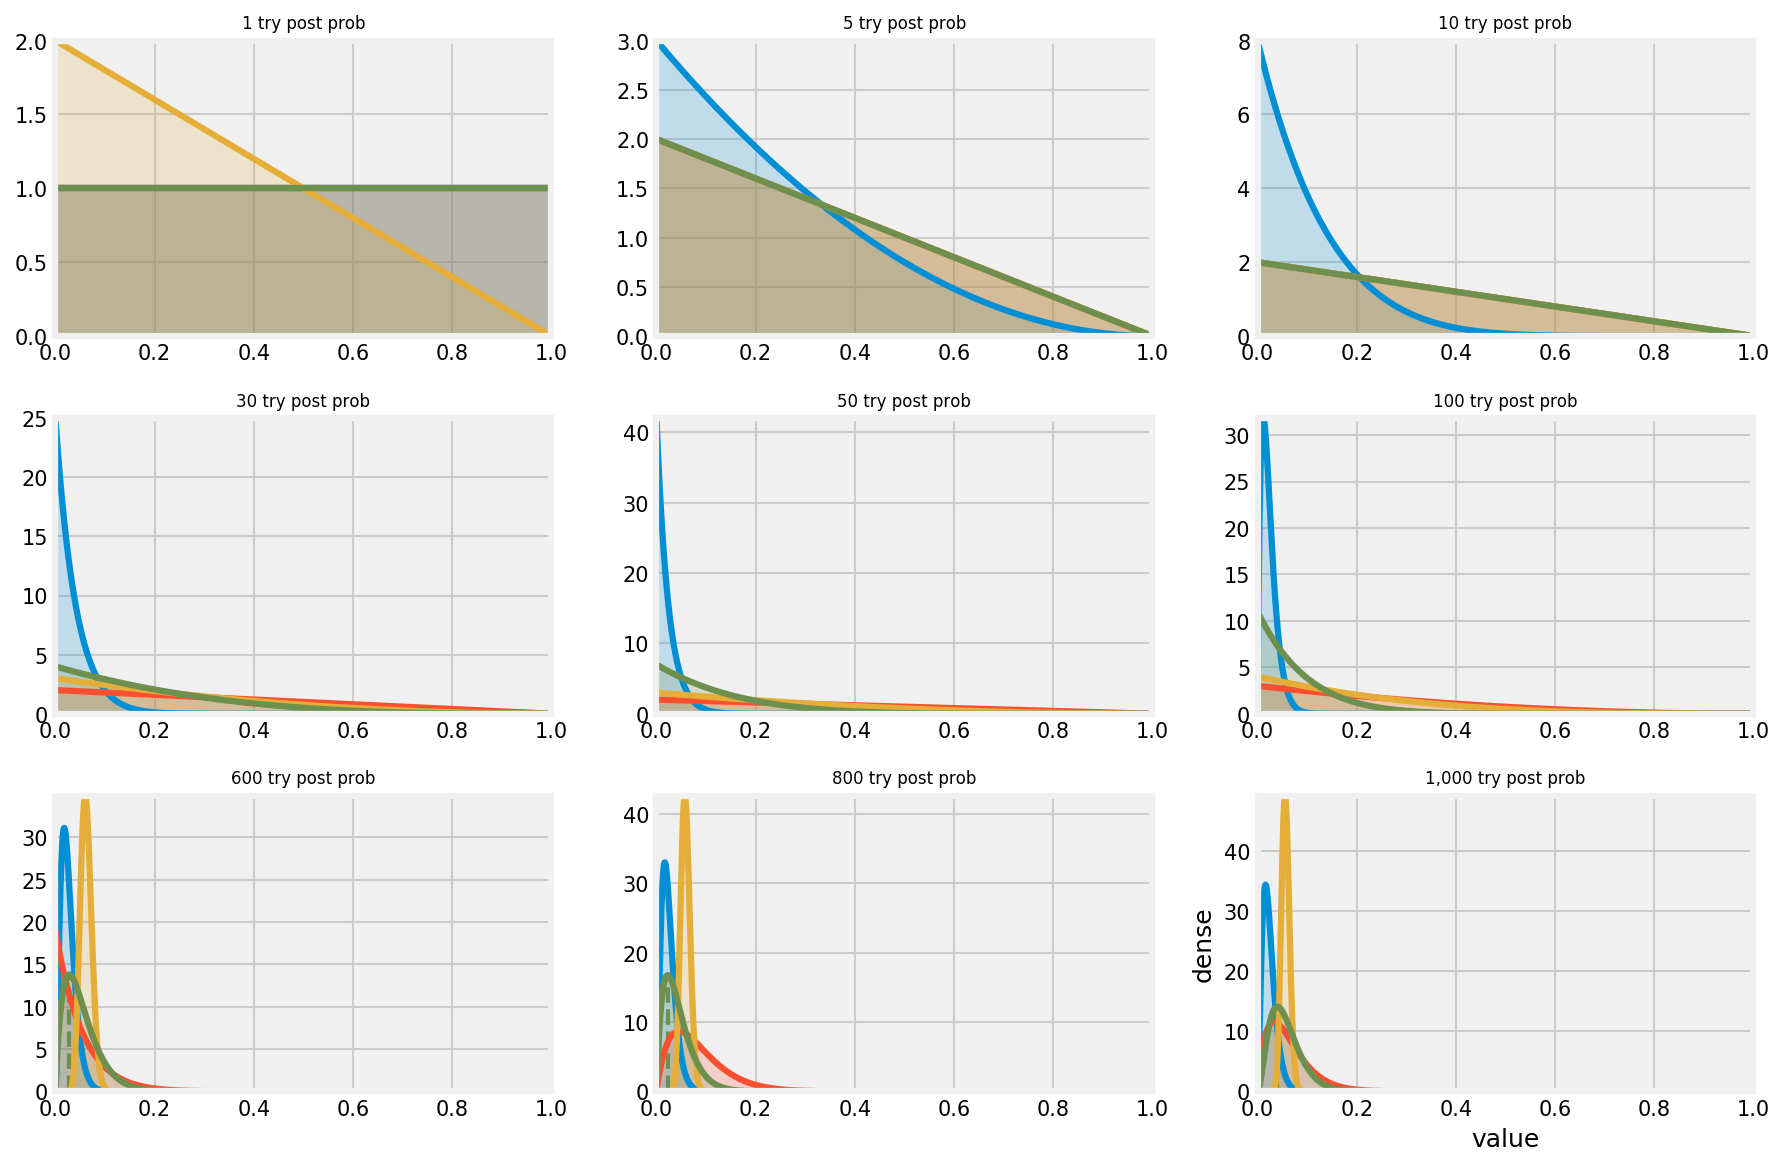

In [22]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(12, 10), dpi=150)

draw_sample = [1, 5, 10, 30, 50, 100, 600, 800, 1000]

for j, i in enumerate(draw_sample):
    plt.subplot(4, 3, j + 1)
    plot_priors(i, k_array, reward_array)
    plt.autoscale(tight=True)
plt.xlabel('value')
plt.ylabel('dense')
plt.title('1,000 try post prob', fontsize = 8)
plt.tight_layout()

In [8]:
def plot_priors(draw, k_array, reward_array, lw=3, alpha=0.2, plt_vlines=True):
    wins = reward_array[:, 0:draw].sum(axis=1)
    # wins_total = wins.sum(axis=1)
    trials = k_array[:, 0:draw].sum(axis=1)
    # trials_total = trials
    success_ratio = wins / trials
    
    for i in range(len(success_ratio)):
        X = np.linspace(0, 1, 1000)
        dist = beta_dist(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(X, dist.pdf(X), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(X, dist.pdf(X), 0, color=c, alpha=alpha)#,
                        #label="기본확률: %.2f" % success_ratio[i])
        
    if plt_vlines:
        plt.vlines(success_ratio[i], 0, dist.pdf(success_ratio[i]), colors=c, linestyles="--", lw=2)
    plt.autoscale(tight="True")
    plt.title("%d try post prob" % draw, fontsize = 8)
    plt.autoscale(tight=True)
    return

In [24]:
print(k_array.sum(axis=1))
print(reward_array[:1].sum(axis=1))
print(reward_array.sum(axis=1) / k_array.sum(axis=1))

[63.]
[17.]
[0.26984127 0.40617849 0.14285714 0.21428571]


In [ ]:
## 3. thompson sampling
### -> 각 밴딧의 결과로 Beta_dist-> 랜덤sampling -> prob 도출 -> 가장 큰 밴딧 고른다
class AdjThompson:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_bandit(self, sent, view, bandit_num, goal=None):
        total_count = sent.sum(axis = 1) # 전체 시행횟수

        if goal == None or np.min(goal.sum(axis = 1)) = 0:
            success_count = view.sum(axis = 1) # view 성공횟수
        else:
            success_count = goal.sum(axis = 1) # goal 성공횟수

        #prob term
        prob_list = [
            np.random.beta(i+1, k+1)
            for i, k
            in zip(success_count, total_count-success_count)
        ]

        if np.random.random() < self.epsilon:
            return np.random.choice(np.delete(list(range(prob_list)), np.argmax(prob_list)))
        else:
            return np.argmax(prob_list)

In [53]:
goal = None
goal == None

True

In [168]:
## 3. thompson sampling
### -> 각 밴딧의 결과로 Beta_dist-> 랜덤sampling -> prob 도출 -> 가장 큰 밴딧 고른다
class AdjThompson:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_bandit(self, sent, view, goal=False):
        total_count = sent # 전체 시행횟수

        if np.all((goal) & (np.min(goal) > 0)):
            success_count = goal # view 성공횟수
        else:
            success_count = view # goal 성공횟수
        print(success_count)

        #prob term
        prob_list = [
            np.random.beta(i+1, k+1)
            for i, k
            in zip(success_count, total_count-success_count)
        ]
        print(prob_list)
        if np.random.random() < self.epsilon:
            prob_list = np.delete(prob_list, np.argmax(prob_list))
            print("under epsilon -> random select campaign")
            rand_select = np.random.choice(prob_list)
            return list(prob_list).index(rand_select)
        else:
            return np.argmax(prob_list)

In [169]:
ATS = AdjThompson(0.2)
sent = np.array([100, 120, 140, 160])
view = np.array([5, 6, 6, 4])
goal = np.array([3, 3, 3, 2])

In [170]:
ATS.choose_bandit(sent, view, goal)

[5 6 6 4]
[0.0667716854730927, 0.037989795214692756, 0.05150366987210983, 0.01744547209583569]


0

In [171]:
ATS.choose_bandit(sent, view)

[5 6 6 4]
[0.03485112106689494, 0.04191445335861635, 0.04321916165166553, 0.019037656974638648]
under epsilon -> random select campaign


2